## Задание.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

**Mobile Games AB Testing with Cookie Cats**

**Cookie Cats** - игра-головоломка для мобильных устройств в жанре "три в ряд".

По мере прохождения игры игроки, в итоге, упираются в ворота, заставляющие их или ждать длительный интервал времени или совершить внутриигровую покупку для продолжения игры. Помимо стимуляции внутриигровых покупок эти ворота выполняют важную функцию - принудительно предоставляют игрокам перерыв от игры, что, по идее, должно привести к повышению и продлению удовольствия от игры.

Но где должны быть размещены ворота? Данное исследование рассматривает два потенциальных места расположения ворот в разрезе удержания игроков: на 30-м (gate_30) и 40-м (gate_40) уровнях.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('результаты А_B.xlsx')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


In [3]:
# Уникальные игроки
df["userid"].nunique()

90189

## Данные

Собранны данные от 90189 игроков, установивших игру во время проведения А/Б тестирования.

Параметры:

**userid** - идентификатор игрока.

**version** - группа игрока в рамках тестирования: контроль (gate_30) и тест (gate_40). Определялась случайным образом в момент установки игры.

**sum_gamerounds** - кол-во сыгранных ироком раундов в течение 14 дней с момента установки игры.

**retention_1** - вернулся ли игрок и сыграл в игру после 1 дня с момента установки игры.

**retention_7** - вернулся ли игрок и сыграл в игру после 7 дней с момента установки игры.

In [4]:
# Проверка кол-ва игроков в группах.
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


Количество игроков в обеих группах сопоставимо.

В данных присутствуют игроки, не игравшие в игру после установки.

In [5]:
df[df["sum_gamerounds"]== 0]["userid"].count()

3994

В игровой индустрии распространённой метрикой является удержание игроков (retention) - доля игроков, возвращающихся в игру после 1-го и 7-ми дней после установки. Чем выше удержание, тем проще нарастить базу игроков.

In [6]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"Доля удержания после 1-го дня: {round(df_retention[0],2)}% \
      \nДоля удержания после 7-ми дней: {round(df_retention[1],2)}%")

Доля удержания после 1-го дня: 44.52%       
Доля удержания после 7-ми дней: 18.61%


Теперь, когда у нас есть ориентир, рассмотрим, как удержание варьируется между группами.

In [7]:
# Расчёт 1-но и 7-ми дневного удержания в группах
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


Оба показателя демонстрируют незначительное снижение удержания в тестовой группе (gate_40), по сравнению с контрольной (gate_30).

Дополнительная проверка результата.

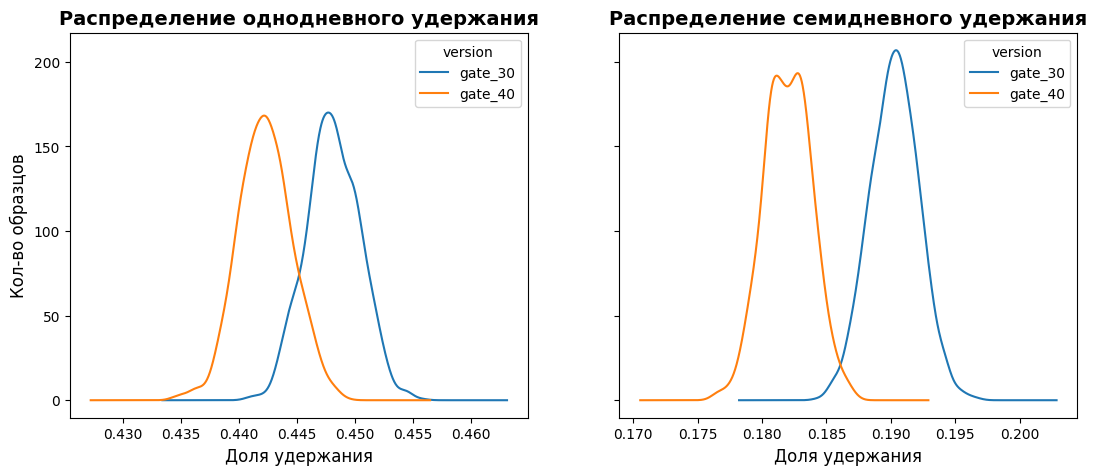

In [8]:
# Бутстреп-анализ
boot_1d = []
boot_7d = []
for i in range(1000):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("Доля удержания",size=12)
ax1.set_ylabel("Кол-во образцов",size=12)
ax1.set_title("Распределение однодневного удержания", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("Доля удержания",size=12)
ax2.set_title("Распределение семидневного удержания", fontweight="bold",size=14)
plt.show()

Графики демострируют незначительные различия в параметрах удержаниях между группами. Рассмотрим их подробнее.

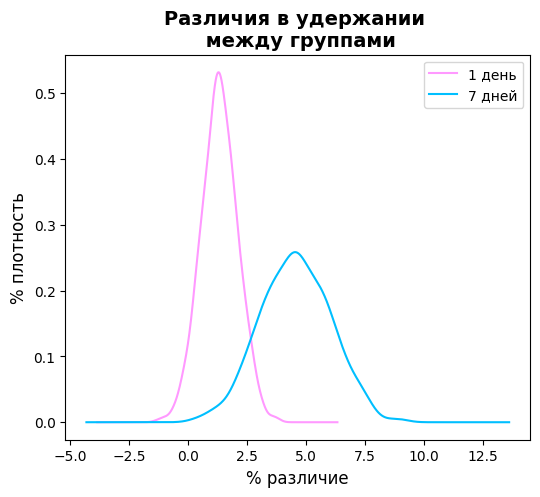

In [9]:
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 день")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 дней")
ax1.set_xlabel("% различие",size=12)
ax1.set_ylabel("% плотность",size=12)
ax1.set_title("Различия в удержании \n между группами", fontweight="bold", size=14)
plt.legend()
plt.show()

Наиболее вероятные различия для удержаний: 1-го дня - 1-2%; 7-ми дней - 2-5%.

In [10]:
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])
print(f"Вероятность того, что удержание 1-го дня больше при расположении ворот на уровне 30: {round(prob_1,2)*100}% \
      \nВероятность того, что удержание 7-го дня больше при расположении ворот на уровне 30: {(prob_7)*100}% ")

Вероятность того, что удержание 1-го дня больше при расположении ворот на  уровне 30: 96.0%       
Вероятность того, что удержание 7-го дня больше при расположении ворот на  уровне 30: 100.0% 


## Заключение

Максимальное удержание игроков после 1-го и 7-ми дней достигается при расположении ворот на уровне 30.